<a href="https://colab.research.google.com/github/paddy-garrett/Covid_Clustering/blob/main/Part_1_Covid_Time_Series_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Time-Series Clustering of Covid-19 Infection Data of Irish Counties***<br><br>
This notebook contains code for the time-series clustering experiments performed in the project.<br><br>
The code is written in R.<br><br>
As the code was written in a Google Colab Jupyter Notebook (because of the GPU capabilities of that platform), R libraries must be installed each time a session is initialised. This can take up to 25 minutes.<br><br>
The dtwclust library is used for the main clustering experiments.<br><br>
The section of the project involving the exploration of a possible correlation between clusters and demographic variables is detailed in separate R files


In [1]:
#to allow R code to be run in Jupyter Notebook --> %%R is the special character denoting an R cell
%load_ext rpy2.ipython

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#installing R packages
%%R
install.packages("xts")
install.packages("dtwclust") 
install.packages("factoextra") 
install.packages("NbClust")

In [ ]:
%%R
library(factoextra)
library(NbClust)
library(xts)
library(dtwclust)
library(dtw)
library(Rcpp)

Creating xts time-series objects from imported CSV file that includes the Covid infection data for Irish counties

In [6]:
#combined ROI and NI data, 06/03/20 - 11/05/21
%%R
comb_data <- read.csv('/content/gdrive/MyDrive/project_data/Combined_0320_0521_CSV.csv')

#renaming Date column to 'Date' instead of i...date
colnames(comb_data)[1] <- "Date"

#creating time-series from the data frame
tss_comb <- xts(comb_data[,-1], order.by=as.Date(comb_data[,1], "%d/%m/%Y"))

#transpose the ts so counties are the rows and dates are the columns
counties_27_ts <- t(tss_comb)

Normalisation of time-series data.

In [7]:
#z-normalisation of time-series dataset
%%R
counties_27_zscore <- zscore(counties_27_ts)

In [ ]:
#function for creating data table of county clusters
%%R
library(data.table)

create_cluster_dt <- function(model, k){
    cluster_df <- data.frame("County" = rownames(counties_27_ts), "Cluster" = model@cluster)
    groups <- list()
    range <- 1:k
    cluster_sizes <- list()
    for (i in range){
        group = list(cluster_df$County[cluster_df$Cluster==i])
        groups[i] <- group
        cluster_sizes[i] <- length(group[[1]]) 
    }
    return (data.table("Cluster Number" = range, "Counties" = groups, "Cluster Size" = cluster_sizes))
}

Typical time-series object from the dataset:

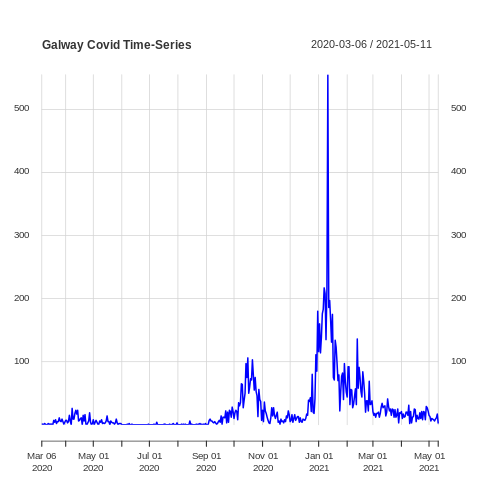

In [9]:
#Example of (pre-normalised) Covid infection time-series included in the dataset
%%R
plot(tss_comb[,7], grid.col = "lightgray", col = "blue", main = "Galway Covid Time-Series")

Application of the Silhouette method to identify optimal number of clusters for configurations with Euclidean distance. An upper limit of 15 clusters was defined to prevent the formation of trivially small clusters (in a dataset of 27 times-series).

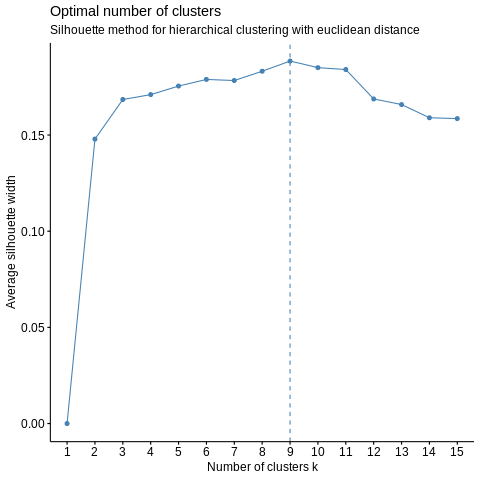

In [10]:
%%R
# Silhouette method for hierarchical clustering
fviz_nbclust(counties_27_zscore, hcut, method = "silhouette",k.max = 15) + 
  labs(subtitle = "Silhouette method for hierarchical clustering with euclidean distance") 

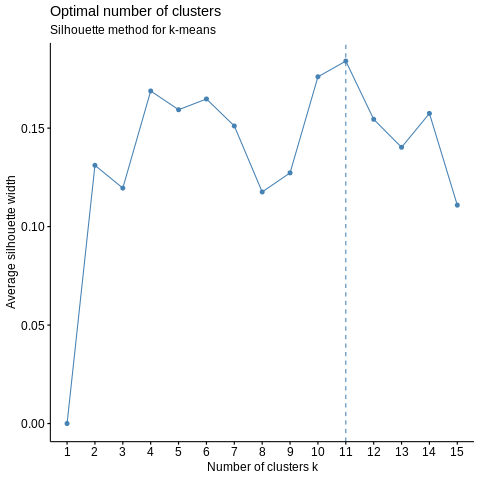

In [11]:
%%R
# Silhouette method for k-means clustering
fviz_nbclust(counties_27_zscore, kmeans, method = "silhouette",k.max = 15) + 
  labs(subtitle = "Silhouette method for k-means") 

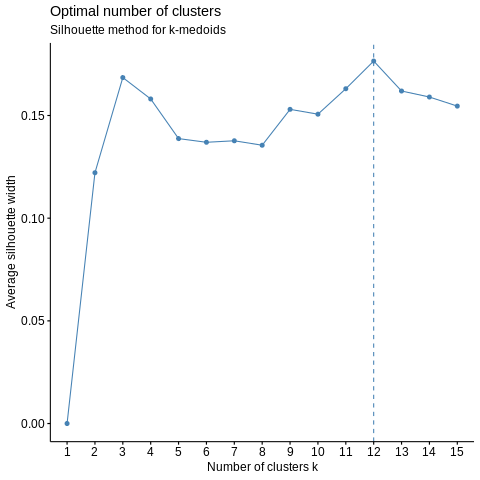

In [12]:
%%R
# Silhouette method for k-medoids/PAM clustering
fviz_nbclust(counties_27_zscore, cluster::pam, method = "silhouette",k.max = 15) + 
  labs(subtitle = "Silhouette method for k-medoids") 

Recording the Cluster Validity Indices(CVI) values of each of the eight configurations in this experiment to identify the best performing configuration.

In [13]:
#Vectors including the CVI values for all tested clustering configurations
%%R
all_sils <- c() #all silhouette scores from configurations
all_chs <- c() # all calinski harabasz
all_ds <- c() # all dunn index
all_cops <- c() # all cop index values

Configuration #1 - K-medoids Partitioning

In [14]:
#K-medoids CVI averaging over 20 seeds

%%R
total_sil = 0
total_ch = 0
total_d = 0
total_cop = 0
seed_range = 1:20


for(i in seed_range){
    kmedoids_01 <- tsclust(counties_27_zscore, type = "partitional", k = 12, 
              distance = "L2", centroid = "pam", 
              seed = i, trace = FALSE)

    
    clust_val <- cvi(kmedoids_01, type = c("Sil", "CH", "D", "COP"))
    total_sil = total_sil + clust_val[1]
    total_ch = total_ch + clust_val[2]
    total_d = total_d + clust_val[3]
    total_cop = total_cop + clust_val[4]
    
}

all_sils <- c(all_sils,total_sil/length(seed_range))
all_chs <- c(all_chs,total_ch/length(seed_range))
all_ds <- c(all_ds,total_d/length(seed_range))
all_cops <- c(all_cops,total_cop/length(seed_range))

Configuration #2 - K-means Partitioning


In [15]:
#K-means CVI averaging over 20 seeds

%%R
total_sil = 0
total_ch = 0
total_d = 0
total_cop = 0
seed_range = 1:20



for(i in seed_range){
    k_means_02 <- tsclust(counties_27_zscore, type = "partitional", k = 11, 
              distance = "L2", centroid = "mean", 
              seed = i, trace = FALSE)#,
              

    
    clust_val <- cvi(k_means_02, type = c("Sil", "CH", "D", "COP"))
    #print(clust_val[1])
    total_sil = total_sil + clust_val[1]
    total_ch = total_ch + clust_val[2]
    total_d = total_d + clust_val[3]
    total_cop = total_cop + clust_val[4]
    
}

all_sils <- c(all_sils,total_sil/length(seed_range))
all_chs <- c(all_chs,total_ch/length(seed_range))
all_ds <- c(all_ds,total_d/length(seed_range))
all_cops <- c(all_cops,total_cop/length(seed_range))

Configurations #3 - #6 : Hierarchical Clustering

In [16]:
#Run all hierarchical configurations
%%R
hierarch_average_03 <- hc <- tsclust(counties_27_zscore, type = "hierarchical", k = 9L, distance = "L2",
               trace = FALSE,
              control = hierarchical_control(method = "average"))

hierarch_ward_04 <- hc <- tsclust(counties_27_zscore, type = "hierarchical", k = 9L, distance = "L2",
               trace = FALSE,
              control = hierarchical_control(method = "ward.D2"))

hierch_centroid_05 <- hc <- tsclust(counties_27_zscore, type = "hierarchical", k = 9L, distance = "L2",
               trace = FALSE,
              control = hierarchical_control(method = "centroid"))

hierch_single_06 <- hc <- tsclust(counties_27_zscore, type = "hierarchical", k = 9L, distance = "L2",
               trace = FALSE,
              control = hierarchical_control(method = "single"))

#cvi calculations for hierarchical configurations
average_03_cvi <- cvi(hierarch_average_03, type = c("Sil", "CH", "D", "COP"))
ward_04_cvi <- cvi(hierarch_ward_04, type = c("Sil", "CH", "D", "COP"))
centroid_05_cvi <- cvi(hierch_centroid_05, type = c("Sil", "CH", "D", "COP"))
single_06_cvi <- cvi(hierch_single_06, type = c("Sil", "CH", "D", "COP"))

#list of CVIs for hierarchical configurations
hierarch_cvis <- list()
hierarch_cvis[[1]] <- average_03_cvi
hierarch_cvis[[2]] <- ward_04_cvi
hierarch_cvis[[3]] <- centroid_05_cvi
hierarch_cvis[[5]] <- single_06_cvi

for (h in hierarch_cvis){
    all_sils <- c(all_sils,h[1])
    all_chs <- c(all_chs,h[2])
    all_ds <- c(all_ds,h[3])
    all_cops <- c(all_cops,h[4])
}



Configurations #7 and #8 : Partitional Clustering with Dynamic Time Warping

In [ ]:
#Performing partitional clustering with dynamic time warping 
#Two configurations - DTW basic and DTW with lower bounding
#Finding average CVI values of twenty iterations/seeds
#Recording these averages for k values from 2 to 15


%%R
k_range = 2:15
cvis_list <- list()
p <- 1

for (ko in k_range){
    total_sil = 0
    total_ch = 0
    total_d = 0
    total_cop = 0
    seed_range = 1:20


    for(i in seed_range){
        #configuration #7 - dtw basic
        #clust_config <- tsclust(counties_27_zscore, k = ko,
        #          distance = "dtw_basic", centroid = "dba",
        #          trace = FALSE, seed = i,
        #          norm = "L2", window.size = 43L,
        #          args = tsclust_args(cent = list(trace = FALSE)))
        
        #configuration #8  - dtw with lower bounding
        clust_config <- tsclust(counties_27_zscore, k = ko,
                  distance = "dtw_lb", centroid = "dba",
                  trace = TRUE, seed = i,
                  norm = "L2", window.size = 43L,
                  control = partitional_control(pam.precompute = FALSE),
                  args = tsclust_args(cent = list(trace = FALSE)))

        
        clust_val <- cvi(clust_config, type = c("Sil", "CH", "D", "COP"))
        total_sil = total_sil + clust_val[1]
        total_ch = total_ch + clust_val[2]
        total_d = total_d + clust_val[3]
        total_cop = total_cop + clust_val[4]
    }

    average_sil = total_sil/length(seed_range)
    average_ch = total_ch/length(seed_range)
    average_d = total_d/length(seed_range)
    average_cop = total_cop/length(seed_range)

    all_average_cvis <- c(average_sil,average_ch,average_d,average_cop)

    
    cvis_list[[p]] <- all_average_cvis
    p <- p + 1

}

In [ ]:
#CVI Values saved to disk in CSV files to reproduce results without re-running code
%%R
sils <- c()
chs <- c()
ds <- c()
cops <- c()

for(i in 1:14){
    sils <- c(sils, cvis_list[[i]][1])
    chs <- c(chs,cvis_list[[i]][2])
    ds <- c(ds,cvis_list[[i]][3])
    cops <- c(cops,cvis_list[[i]][4])
}


k_numb <- 2:15
#dtw_basic <- data.frame("K Value" = k_numb,"Silhouette_Score" = sils,"CH" = chs, "Dunn" = ds, "COP" = cops)
dtw_lb_cvis <- data.frame("K Value" = k_numb,"Silhouette_Score" = sils,"CH" = chs, "Dunn" = ds, "COP" = cops)

#write.csv(dtw_lb_cvis,"dtw_basic.csv", row.names = FALSE)
write.csv(dtw_lb_cvis,"dtw_lb_cvis.csv", row.names = FALSE)

In [17]:
#Reading average CVI values for configurations #7 and #8 from disk 
%%R
dtw_bas <- read.csv('/content/gdrive/MyDrive/project_data/dtw_basic.csv')
dtw_dba <- read.csv('/content/gdrive/MyDrive/project_data/dtw_dba_cvis.csv')

In [18]:
#adding dtw_basic CVI values to vectors containing all CVIs
%%R
all_sils <- c(all_sils,dtw_bas$Silhouette_Score[[1]])
all_chs <- c(all_chs,dtw_bas$CH[[1]])
all_ds <- c(all_ds,dtw_bas$Dunn[[1]])
all_cops <- c(all_cops,dtw_bas$COP[[1]])

In [19]:
#adding dtw_lb CVI values to vectors containing all CVIs
%%R
all_sils <- c(all_sils,dtw_dba$Silhouette_Score[[1]])
all_chs <- c(all_chs,dtw_dba$CH[[1]])
all_ds <- c(all_ds,dtw_dba$Dunn[[1]])
all_cops <- c(all_cops,dtw_dba$COP[[1]])

A dataframe summarising all configurations and their CVI values.

In [20]:
#Creating dataframe containing summary of all clustering configurations and their final CVI values
%%R
types <- c("Partitional (K-Medoids)", "Partitional (K-Means)", "Hierarchical","Hierarchical","Hierarchical","Hierarchical","Partitional (DTW)","Partitional (DTW)")
distance_metric <- c("Euclidean","Euclidean","Euclidean","Euclidean","Euclidean","Euclidean", "DTW Basic", "DTW LB")
k_value <- c(12,11,9,9,9,9,2,2)
linkage_control <- c("NA","NA", "Average", "Ward","Centroid","Single","NA","NA")
centroid <- c("PAM", "Mean","NA","NA","NA","NA","DBA","DBA")
window_size_val <- c("43","43","NA","NA","NA","NA","43","43")

config_IDs <- 1:8
config_table <- data.frame("Configuration ID" = config_IDs,"Clustering Type" = types,"Distance Measure" = distance_metric,"K Value"= k_value,
                           "Linkage"= linkage_control,"Centroid" = centroid,"Silhouette" = all_sils, "CH Score" = all_chs, "Dunn" = all_ds, "COP" = all_cops )

In [21]:
%%R
config_table

  Configuration.ID         Clustering.Type Distance.Measure K.Value  Linkage
1                1 Partitional (K-Medoids)        Euclidean      12       NA
2                2   Partitional (K-Means)        Euclidean      11       NA
3                3            Hierarchical        Euclidean       9  Average
4                4            Hierarchical        Euclidean       9     Ward
5                5            Hierarchical        Euclidean       9 Centroid
6                6            Hierarchical        Euclidean       9   Single
7                7       Partitional (DTW)        DTW Basic       2       NA
8                8       Partitional (DTW)           DTW LB       2       NA
  Centroid Silhouette  CH.Score      Dunn       COP
1      PAM 0.07184315  2.781889 0.4666718 0.3120735
2     Mean 0.07949016  2.296850 0.4576509 0.3079505
3       NA 0.17452380  4.357268 0.6769818 0.3735042
4       NA 0.18847315  3.588572 0.6306880 0.3585110
5       NA 0.01172029  1.247047 0.5273628 0.460

In [27]:
#Creating data tables that display the final cluster composition of hierarchical clustering with average linkage and ward linkage
%%R
average_link_clusters <- create_cluster_dt(hierarch_average_03, 9)
ward_clusters <- create_cluster_dt(hierarch_ward_04, 9)

Cluster composition of two best performing configurations.

In [29]:
#Clusters formed by configuration #3 - Hierarchical clustering with average linkage
%%R
print(average_link_clusters)

   Cluster Number                                     Counties Cluster Size
1:              1            Carlow,Kilkenny,Waterford,Wexford            4
2:              2                                  Cavan,Meath            2
3:              3 Clare,Cork,Dublin,Kerry,Kildare,Limerick,...           10
4:              4                        Donegal,Leitrim,Sligo            3
5:              5                        Galway,Mayo,Roscommon            3
6:              6                                 Laois,Offaly            2
7:              7                                     Longford            1
8:              8                                    Westmeath            1
9:              9                             Northern.Ireland            1


In [30]:
#Clusters formed by configuration #4 - Hierarchical clustering with Ward linkage
%%R
print(ward_clusters)

   Cluster Number                                     Counties Cluster Size
1:              1            Carlow,Kilkenny,Waterford,Wexford            4
2:              2                                  Cavan,Meath            2
3:              3 Clare,Cork,Kerry,Limerick,Louth,Monaghan,...            7
4:              4                        Donegal,Leitrim,Sligo            3
5:              5                       Dublin,Kildare,Wicklow            3
6:              6                        Galway,Mayo,Roscommon            3
7:              7                                 Laois,Offaly            2
8:              8                           Longford,Westmeath            2
9:              9                             Northern.Ireland            1


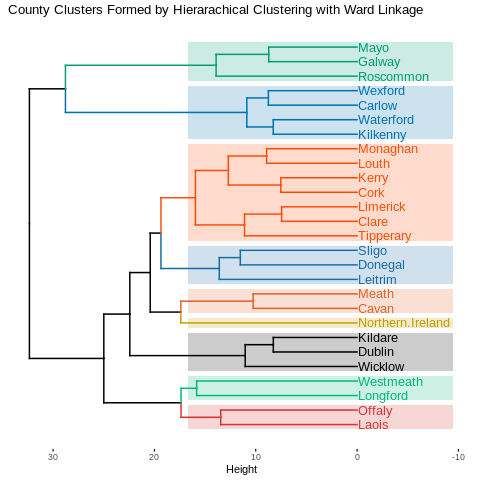

In [31]:
#Dendrogram of clusters formed by hierarchical clustering with Ward linkage
%%R
clus_colours <- c("#da3434", "#00b879", "black","#c59d00",  "#e36228", "#166da6",
          "#FC4E07","#0072B2","#009E73")

library(repr)
options(repr.plot.width=15, repr.plot.height=8)
pl <- fviz_dend(hierarch_ward_04, k = 9,                 
          cex = 0.9,                 
          k_colors = clus_colours,
          horiz = TRUE,
          color_labels_by_k =TRUE, rect = TRUE,  # color labels by groups
          rect_border = clus_colours,
          rect_fill = TRUE,
          labels_track_height = 9,
          main = "County Clusters Formed by Hierarachical Clustering with Ward Linkage",
          #ggtheme = theme_gray()     # Change theme
          )

print(pl)

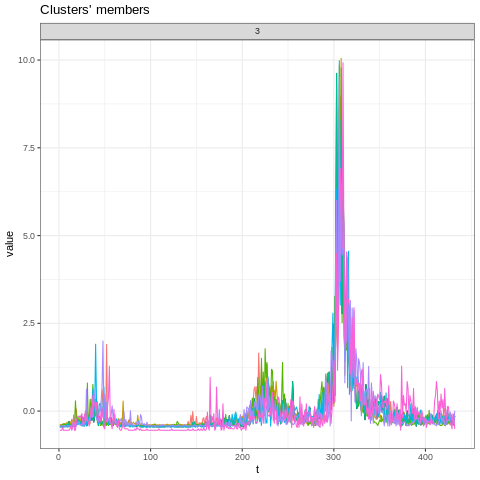

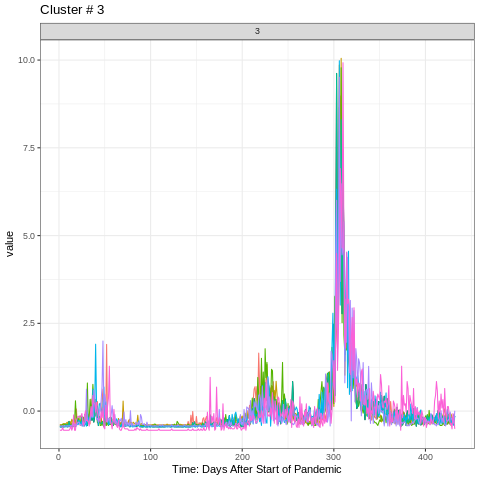

In [37]:
#Example of time-series cluster plot - in this case Cluster #3 of hierarchical clustering with Ward linkage 
%%R
print(plot(hierarch_ward_04,  type = "sc", clus = 3, linetype = "solid") + labs(title = "Cluster # 3", x = "Time: Days After Start of Pandemic"))